In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from time import time
import os

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('..')

import isolation
import sample_players
import run_match
import my_baseline_player as custom
import book as b

from multiprocessing.pool import ThreadPool as Pool

Populating the interactive namespace from numpy and matplotlib


/home/miguel/anaconda3/envs/aind/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Constant parameteres
time_limit = 150
depth = 4
full_search_depth = 2
matches_per_opening = 3

# Create the agents that will play
agent_names = ('CustomPlayer1', 'CustomPlayer2')
agent1 = isolation.Agent(custom.CustomPlayer, agent_names[0])
agent2 = isolation.Agent(custom.CustomPlayer, agent_names[1])
agents = (agent1, agent2)

# Get the initial states
root = isolation.isolation.Isolation()
opening_states = list(b.get_full_states(root, depth=full_search_depth))

# Generate the matches
matches = [(agents, state, time_limit, match_id) 
           for match_id, state in enumerate(opening_states)]
matches = matches * 3
print('Generated {} matches.'.format(len(matches)))

Generated 29403 matches.


In [3]:
num_processes = 4
batch_size = 100
batch_num_file = 'batch_num.txt'

# Small test for debugging
# matches = matches[:100]

# Create or load the book
book = b.load_latest_book(depth=depth)

# Make some batches to save the results once in a while
x = matches
batches = [x[i*batch_size:(i+1)*batch_size] 
           for i in range(len(x) // batch_size + (len(x) % batch_size != 0))]

# Get only the unprocessed batches
if os.path.exists(batch_num_file):
    with open(batch_num_file, 'r') as file:
        last_batch = int(file.read())
else:
    last_batch = -1

# Now fill the book!
pool = Pool(num_processes)

for batch_num in range(last_batch + 1, len(batches)):
    tic = time.time()
    batch = batches[batch_num]
    print('Processing batch {} of {}'.format(batch_num, len(batches)))
    for result in pool.imap_unordered(isolation.play, batch):
        winner, game_history, match_id = result
        # print('Results for match {}: {} wins.'.format(match_id, winner.name))
        _, state, _, _ = matches[match_id]
        if state.locs[1] is not None:
            game_history.insert(0,state.locs[1])
        if state.locs[0] is not None:
            game_history.insert(0,state.locs[0])
        root = isolation.isolation.Isolation()
        b.process_game_history(root,
                               game_history, 
                               book,
                               agent_names.index(winner.name),
                               active_player=state.ply_count % 2,
                               depth=depth)
    toc = time.time()
    print('Batch time {} seconds.'.format((toc-tic)))
    b.save_book(book)
    with open(batch_num_file, 'w') as file:
        file.write(str(batch_num))
    b.remove_old_books()

Processing batch 163 of 295
Batch time 275.32950806617737 seconds.
Saving: book2018-06-15_08S09S10.649374.pkl
rm book2018-06-14_19S13S38.799745.pkl
Processing batch 164 of 295
Batch time 271.85555124282837 seconds.
Saving: book2018-06-15_08S13S42.904798.pkl
rm book2018-06-15_08S09S10.649374.pkl
Processing batch 165 of 295
Batch time 269.90383672714233 seconds.
Saving: book2018-06-15_08S18S13.184027.pkl
rm book2018-06-15_08S13S42.904798.pkl
Processing batch 166 of 295
Batch time 282.55953192710876 seconds.
Saving: book2018-06-15_08S22S56.123448.pkl
rm book2018-06-15_08S18S13.184027.pkl
Processing batch 167 of 295
Batch time 273.7431254386902 seconds.
Saving: book2018-06-15_08S27S30.252834.pkl
rm book2018-06-15_08S22S56.123448.pkl
Processing batch 168 of 295
Batch time 272.64021825790405 seconds.
Saving: book2018-06-15_08S32S03.279418.pkl
rm book2018-06-15_08S27S30.252834.pkl
Processing batch 169 of 295
Batch time 269.11245703697205 seconds.
Saving: book2018-06-15_08S36S32.779847.pkl
rm 

In [4]:
sum(abs(value) for value in book.values())

142391

In [5]:
29403*34 / (10*3600)  # Estimated time in hours

27.7695

In [6]:
import pandas as pd

v = pd.Series(list(book.values()))

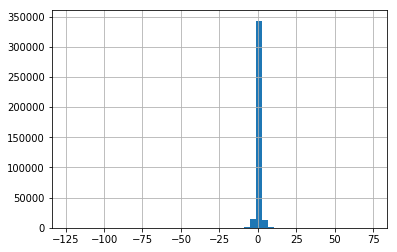

In [7]:
v.hist(bins=50)

In [8]:
v.describe()

count    374097.000000
mean         -0.001997
std           1.403731
min        -124.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          74.000000
dtype: float64

In [9]:
v.min()

-124

In [10]:
worst = min(((k, v) for k, v in book.items()), key=lambda x: x[1])
worst[0]

(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
 57)

In [26]:
from isolation.isolation import Isolation
state = Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None))

print(isolation.DebugState.from_state(state.result(57)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   | 1 |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +



What about the other symmetrical ones

In [27]:
s1 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 56)
s2 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 58)
s3 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 70)
s4 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 44)

In [28]:
book[s1]

-24

In [29]:
book[s2]

-24

In [31]:
book[s3]

52

In [32]:
book[s4]

52

### I think I have ply_count=1,2,3,4 in the book but not ply_count=0

In [57]:
len(book.items())

374097

### Idea: show a heat matrix for the initial move

In [21]:
first = {item:value for item, value in book.items() if item[0].ply_count==0}

In [22]:
len(first)

99

In [37]:
first

{(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  0): -4,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  1): 50,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  2): -22,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  3): -13,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  4): -38,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  5): 42,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  6): -38,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  7): -13,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  8): -22,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  9): 50,
 (Isolation(bo

In [41]:
pos_value = {key[1]:value for key,value in first.items()}
pos_value

{0: -4,
 1: 50,
 2: -22,
 3: -13,
 4: -38,
 5: 42,
 6: -38,
 7: -13,
 8: -22,
 9: 50,
 10: -4,
 13: -8,
 14: 33,
 15: -16,
 16: 37,
 17: -78,
 18: 74,
 19: -78,
 20: 37,
 21: -16,
 22: 33,
 23: -8,
 26: -30,
 27: -10,
 28: 40,
 29: -14,
 30: -68,
 31: -72,
 32: -68,
 33: -14,
 34: 40,
 35: -10,
 36: -30,
 39: -52,
 40: -10,
 41: 31,
 42: -34,
 43: 15,
 44: 52,
 45: 15,
 46: -34,
 47: 31,
 48: -10,
 49: -52,
 52: -48,
 53: 4,
 54: -30,
 55: -52,
 56: -24,
 57: -124,
 58: -24,
 59: -52,
 60: -30,
 61: 4,
 62: -48,
 65: -52,
 66: -10,
 67: 31,
 68: -34,
 69: 15,
 70: 52,
 71: 15,
 72: -34,
 73: 31,
 74: -10,
 75: -52,
 78: -30,
 79: -10,
 80: 40,
 81: -14,
 82: -68,
 83: -72,
 84: -68,
 85: -14,
 86: 40,
 87: -10,
 88: -30,
 91: -8,
 92: 33,
 93: -16,
 94: 37,
 95: -78,
 96: 74,
 97: -78,
 98: 37,
 99: -16,
 100: 33,
 101: -8,
 104: -4,
 105: 50,
 106: -22,
 107: -13,
 108: -38,
 109: 42,
 110: -38,
 111: -13,
 112: -22,
 113: 50,
 114: -4}

In [45]:
filled_vals = dict(zip(range(115),[0]*115))
filled_vals.update(pos_value)
filled_vals

{0: -4,
 1: 50,
 2: -22,
 3: -13,
 4: -38,
 5: 42,
 6: -38,
 7: -13,
 8: -22,
 9: 50,
 10: -4,
 11: 0,
 12: 0,
 13: -8,
 14: 33,
 15: -16,
 16: 37,
 17: -78,
 18: 74,
 19: -78,
 20: 37,
 21: -16,
 22: 33,
 23: -8,
 24: 0,
 25: 0,
 26: -30,
 27: -10,
 28: 40,
 29: -14,
 30: -68,
 31: -72,
 32: -68,
 33: -14,
 34: 40,
 35: -10,
 36: -30,
 37: 0,
 38: 0,
 39: -52,
 40: -10,
 41: 31,
 42: -34,
 43: 15,
 44: 52,
 45: 15,
 46: -34,
 47: 31,
 48: -10,
 49: -52,
 50: 0,
 51: 0,
 52: -48,
 53: 4,
 54: -30,
 55: -52,
 56: -24,
 57: -124,
 58: -24,
 59: -52,
 60: -30,
 61: 4,
 62: -48,
 63: 0,
 64: 0,
 65: -52,
 66: -10,
 67: 31,
 68: -34,
 69: 15,
 70: 52,
 71: 15,
 72: -34,
 73: 31,
 74: -10,
 75: -52,
 76: 0,
 77: 0,
 78: -30,
 79: -10,
 80: 40,
 81: -14,
 82: -68,
 83: -72,
 84: -68,
 85: -14,
 86: 40,
 87: -10,
 88: -30,
 89: 0,
 90: 0,
 91: -8,
 92: 33,
 93: -16,
 94: 37,
 95: -78,
 96: 74,
 97: -78,
 98: 37,
 99: -16,
 100: 33,
 101: -8,
 102: 0,
 103: 0,
 104: -4,
 105: 50,
 106: -22,
 10

In [50]:
W = 11
x = list(filled_vals.values())
rows = [x[i*(W+2):(i+1)*(W+2)] 
           for i in range(len(x) // (W+2) + (len(x) % (W+2) != 0))]

In [51]:
rows

[[-4, 50, -22, -13, -38, 42, -38, -13, -22, 50, -4, 0, 0],
 [-8, 33, -16, 37, -78, 74, -78, 37, -16, 33, -8, 0, 0],
 [-30, -10, 40, -14, -68, -72, -68, -14, 40, -10, -30, 0, 0],
 [-52, -10, 31, -34, 15, 52, 15, -34, 31, -10, -52, 0, 0],
 [-48, 4, -30, -52, -24, -124, -24, -52, -30, 4, -48, 0, 0],
 [-52, -10, 31, -34, 15, 52, 15, -34, 31, -10, -52, 0, 0],
 [-30, -10, 40, -14, -68, -72, -68, -14, 40, -10, -30, 0, 0],
 [-8, 33, -16, 37, -78, 74, -78, 37, -16, 33, -8, 0, 0],
 [-4, 50, -22, -13, -38, 42, -38, -13, -22, 50, -4]]

In [52]:
for i in range(len(rows)-1):
    rows[i] =rows[i][:-2]
rows

[[-4, 50, -22, -13, -38, 42, -38, -13, -22, 50, -4],
 [-8, 33, -16, 37, -78, 74, -78, 37, -16, 33, -8],
 [-30, -10, 40, -14, -68, -72, -68, -14, 40, -10, -30],
 [-52, -10, 31, -34, 15, 52, 15, -34, 31, -10, -52],
 [-48, 4, -30, -52, -24, -124, -24, -52, -30, 4, -48],
 [-52, -10, 31, -34, 15, 52, 15, -34, 31, -10, -52],
 [-30, -10, 40, -14, -68, -72, -68, -14, 40, -10, -30],
 [-8, 33, -16, 37, -78, 74, -78, 37, -16, 33, -8],
 [-4, 50, -22, -13, -38, 42, -38, -13, -22, 50, -4]]

In [54]:
rows = np.array(rows)
rows

array([[  -4,   50,  -22,  -13,  -38,   42,  -38,  -13,  -22,   50,   -4],
       [  -8,   33,  -16,   37,  -78,   74,  -78,   37,  -16,   33,   -8],
       [ -30,  -10,   40,  -14,  -68,  -72,  -68,  -14,   40,  -10,  -30],
       [ -52,  -10,   31,  -34,   15,   52,   15,  -34,   31,  -10,  -52],
       [ -48,    4,  -30,  -52,  -24, -124,  -24,  -52,  -30,    4,  -48],
       [ -52,  -10,   31,  -34,   15,   52,   15,  -34,   31,  -10,  -52],
       [ -30,  -10,   40,  -14,  -68,  -72,  -68,  -14,   40,  -10,  -30],
       [  -8,   33,  -16,   37,  -78,   74,  -78,   37,  -16,   33,   -8],
       [  -4,   50,  -22,  -13,  -38,   42,  -38,  -13,  -22,   50,   -4]])

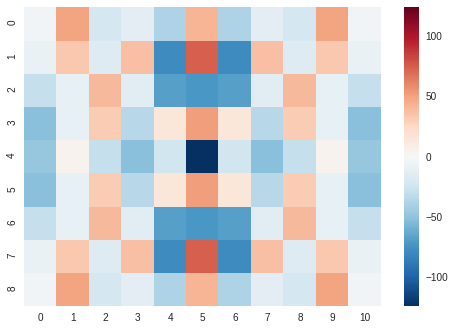

In [56]:
import seaborn as sns
sns.heatmap(rows)

In [66]:
second = {item:value for item, value in book.items() if item[0].ply_count==1}

In [67]:
len(second)

9702

In [68]:
pd.Series(list(second.values())).describe()

count    9702.000000
mean        0.102659
std         5.652677
min       -12.000000
25%        -4.000000
50%         0.000000
75%         4.000000
max        12.000000
dtype: float64

In [58]:
third = {item:value for item, value in book.items() if item[0].ply_count==2}

In [59]:
len(third)

55096

In [65]:
pd.Series(list(third.values())).describe()

count    55096.000000
mean        -0.018078
std          1.967012
min         -8.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          6.000000
dtype: float64

In [69]:
fourth = {item:value for item, value in book.items() if item[0].ply_count==3}
len(fourth)

309200

In [75]:
pd.Series(list(fourth.values())).describe()

count    309200.000000
mean          0.000805
std           0.406460
min          -4.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
dtype: float64

In [76]:
sum(np.array(list(third.values())) != 0)

32372

In [74]:
sum(np.array(list(fourth.values())) != 0)

9944